In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a consistent BATCH_SIZE
BATCH_SIZE = 64

Using device: cuda


In [4]:
#clear directory
!cd /kaggle/working/
!rm -rf *

In [5]:
import shutil
import os

# Path to your Kaggle input dataset
input_path = "/kaggle/input/realwaste-dataset/realwaste-main/RealWaste"

# Path to your working directory
working_path = "/kaggle/working/realwaste"

# Copy the entire folder
shutil.copytree(input_path, working_path, dirs_exist_ok=True)

print("✅ Dataset copied successfully to working directory!")


✅ Dataset copied successfully to working directory!


In [6]:
import os
import shutil
import random

# Source dataset path
source_dir = "/kaggle/working/realwaste"

# Destination base directory (in working directory)
base_output = "/kaggle/working/realwaste_split"

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create output directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_output, split), exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # skip non-folder items

    # List all image files in class folder
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    # Compute split indices
    total = len(images)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    # Split images
    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    # Copy images into respective folders
    for split, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_dir = os.path.join(base_output, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

        for fname in file_list:
            src = os.path.join(class_path, fname)
            dst = os.path.join(split_dir, fname)
            shutil.copy2(src, dst)

    print(f"✅ {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\n🎯 Dataset successfully split into train, val, and test folders!")


✅ Vegetation: 305 train, 65 val, 66 test
✅ Miscellaneous Trash: 346 train, 74 val, 75 test
✅ Plastic: 644 train, 138 val, 139 test
✅ Paper: 350 train, 75 val, 75 test
✅ Textile Trash: 222 train, 48 val, 48 test
✅ Food Organics: 287 train, 62 val, 62 test
✅ Cardboard: 322 train, 69 val, 70 test
✅ Glass: 294 train, 63 val, 63 test
✅ Metal: 553 train, 118 val, 119 test

🎯 Dataset successfully split into train, val, and test folders!


In [7]:
# --- Kaggle Data Path Configuration ---

BASE_DATA_PATH = "/kaggle/working/realwaste_split" 
# Verify the paths are correct for your specific Kaggle setup.
train_dir = os.path.join(BASE_DATA_PATH, "train")
val_dir = os.path.join(BASE_DATA_PATH, "val")
test_dir = os.path.join(BASE_DATA_PATH, "test")

# Define standard normalization parameters (e.g., ImageNet mean/std)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Removed all data augmentation for the training set as requested
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Use Resize instead of RandomResizedCrop
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) 
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create ImageFolder datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 9


In [8]:
# Calculate class weights for WeightedRandomSampler (for imbalanced data handling)
class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)

# Compute class weights (inverse of frequency)
class_weights_tensor = 1. / torch.tensor(class_counts, dtype=torch.float)

# Ensure sample_weights are floats for the sampler
sample_weights = [class_weights_tensor[label].item() for label in train_dataset.targets]

print("\n📊 Class counts per category:")
for cls, count in zip(train_dataset.classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\n⚖️ Class weights (inverse of frequency):")
for cls, w in zip(train_dataset.classes, class_weights_tensor):
    print(f"  {cls:15s}: {w:.6f}")

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create DataLoaders
# Set num_workers based on your Kaggle environment's resources (usually 2 or 4 is safe)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print("\n✅ DataLoaders and WeightedRandomSampler created successfully!")
print(f"➡️ Total samples in epoch: {len(sample_weights)}")
print(f"➡️ Training Batch size: {train_loader.batch_size}")
print(f"➡️ Validation Batch size: {val_loader.batch_size}")
print(f"➡️ Total training batches per epoch: {len(train_loader)}")

Class counts: [322 287 294 553 346 350 644 222 305]

📊 Class counts per category:
  Cardboard      : 322
  Food Organics  : 287
  Glass          : 294
  Metal          : 553
  Miscellaneous Trash: 346
  Paper          : 350
  Plastic        : 644
  Textile Trash  : 222
  Vegetation     : 305

⚖️ Class weights (inverse of frequency):
  Cardboard      : 0.003106
  Food Organics  : 0.003484
  Glass          : 0.003401
  Metal          : 0.001808
  Miscellaneous Trash: 0.002890
  Paper          : 0.002857
  Plastic        : 0.001553
  Textile Trash  : 0.004505
  Vegetation     : 0.003279

✅ DataLoaders and WeightedRandomSampler created successfully!
➡️ Total samples in epoch: 3323
➡️ Training Batch size: 64
➡️ Validation Batch size: 64
➡️ Total training batches per epoch: 52


In [13]:
# Define the custom CNN model (WasteCNN)
class WasteCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()
        # Convolutional Layers with Batch Normalization and Max Pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Dynamically determine the size of the feature maps after convolutional layers
        self._to_linear = None
        self.calculate_flatten_size(224) # Assuming an input image size of 224x224

        # Fully Connected Layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.dropout = nn.Dropout(0.5) # Dropout for regularization
        self.fc2 = nn.Linear(256, num_classes) # Output layer

    def calculate_flatten_size(self, input_size):
        # Pass a dummy tensor through the convolutional layers to determine the flattened size
        with torch.no_grad():
            x = torch.zeros(1, 3, input_size, input_size)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self._to_linear) # Flatten the output
        x = self.dropout(F.relu(self.fc1(x))) # Apply dropout and ReLU to the first FC layer
        x = self.fc2(x) # Output layer (logits)
        return x

print("WasteCNN model class defined and ready for use.")

WasteCNN model class defined and ready for use.


In [14]:
# Function to get a new model instance, optionally with identical initial weights
# For a fair comparison, all models should ideally start from the same initial random weights.
def get_fresh_model_for_comparison(num_classes, device, base_model_path='initial_model_weights.pth'):
    if not os.path.exists(base_model_path):
        # If no base model state exists, create one and save its initial state
        initial_model = WasteCNN(num_classes=num_classes).to(device)
        torch.save(initial_model.state_dict(), base_model_path)
        print(f"Created and saved initial model weights to {base_model_path}")
        return initial_model
    else:
        # Load the saved initial state into a new model instance
        new_model = WasteCNN(num_classes=num_classes).to(device)
        new_model.load_state_dict(torch.load(base_model_path))
        return new_model

# --- Define a generic Training Function for Optimizer Comparison ---\n
def run_optimizer_training_comparison(model_instance, optimizer_name, optimizer_obj, criterion_obj, scheduler_obj, num_epochs_comp, train_loader_comp, val_loader_comp, device_comp):
    print(f"\nTraining with {optimizer_name} for {num_epochs_comp} epochs...")

    current_train_losses = []
    current_train_accuracies = []
    current_val_losses = []
    current_val_accuracies = []

    best_val_acc_run = 0.0
    model_path_run = f'best_model_comparison_{optimizer_name.lower().replace(" ", "_").replace("-", "_")}.pth'

    for epoch in range(num_epochs_comp):
        # Training phase
        model_instance.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)

            optimizer_obj.zero_grad() # Zero the parameter gradients
            outputs = model_instance(images) # Forward pass
            loss = criterion_obj(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer_obj.step() # Optimize

            running_loss += loss.item() * images.size(0) # Aggregate loss

            _, predicted = torch.max(outputs, 1) # Get predictions
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader_comp.dataset)
        epoch_train_accuracy = 100 * train_correct / train_total
        current_train_losses.append(epoch_train_loss)
        current_train_accuracies.append(epoch_train_accuracy)

        if scheduler_obj:
            scheduler_obj.step() # Update learning rate if a scheduler is provided

        # Validation phase
        model_instance.eval() # Set model to evaluation mode
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad(): # Disable gradient computation
            val_loop = tqdm(val_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device_comp), labels.to(device_comp)
                outputs = model_instance(images)
                loss = criterion_obj(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader_comp.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        current_val_losses.append(epoch_val_loss)
        current_val_accuracies.append(epoch_val_accuracy)

        print(f"  {optimizer_name} - Epoch [{epoch+1}/{num_epochs_comp}] "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.2f}%")

        if epoch_val_accuracy > best_val_acc_run:
            best_val_acc_run = epoch_val_accuracy
            torch.save(model_instance.state_dict(), model_path_run) # Save best model for current optimizer

    print(f"--- {optimizer_name} training finished. Best Val Accuracy: {best_val_acc_run:.2f}% ---")
    return current_train_losses, current_train_accuracies, current_val_losses, current_val_accuracies, model_path_run

print("Helper functions `get_fresh_model_for_comparison` and `run_optimizer_training_comparison` defined.")

Helper functions `get_fresh_model_for_comparison` and `run_optimizer_training_comparison` defined.


In [16]:
print("\n" + "="*50)
print("       Starting Optimizer Performance Comparison Training       ")
print("="*50 + "\n")

# Create a 'base' model to get initial weights that all comparison models will share.
_ = get_fresh_model_for_comparison(num_classes, device) # Call once to save the initial state

# --- Optimizer Configuration for Comparison ---
NUM_EPOCHS_COMP = 20

# Common Loss Function
criterion_comp = nn.CrossEntropyLoss()

# 1. Adam Optimizer Configuration
model_adam_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
optimizer_adam_comp = optim.Adam(model_adam_comp.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_adam_comp = StepLR(optimizer_adam_comp, step_size=10, gamma=0.1)

# 2. Standard SGD Optimizer Configuration
model_sgd_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
optimizer_sgd_comp = optim.SGD(model_sgd_comp.parameters(), lr=0.01, weight_decay=1e-4)
scheduler_sgd_comp = StepLR(optimizer_sgd_comp, step_size=10, gamma=0.1)

# 3. SGD with Momentum Optimizer Configuration
model_sgd_momentum_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
optimizer_sgd_momentum_comp = optim.SGD(model_sgd_momentum_comp.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_sgd_momentum_comp = StepLR(optimizer_sgd_momentum_comp, step_size=10, gamma=0.1)

# --- Run Training for each Optimizer ---
adam_results = run_optimizer_training_comparison(
    model_adam_comp, "Adam", optimizer_adam_comp, criterion_comp, scheduler_adam_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
adam_train_losses, adam_train_accuracies, adam_val_losses, adam_val_accuracies, adam_comp_model_path = adam_results

sgd_results = run_optimizer_training_comparison(
    model_sgd_comp, "Standard SGD", optimizer_sgd_comp, criterion_comp, scheduler_sgd_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_train_losses, sgd_train_accuracies, sgd_val_losses, sgd_val_accuracies, sgd_comp_model_path = sgd_results

sgd_momentum_results = run_optimizer_training_comparison(
    model_sgd_momentum_comp, "SGD with Momentum", optimizer_sgd_momentum_comp, criterion_comp, scheduler_sgd_momentum_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_momentum_train_losses, sgd_momentum_train_accuracies, sgd_momentum_val_losses, sgd_momentum_val_accuracies, sgd_momentum_comp_model_path = sgd_momentum_results

print("\nOptimizer comparison training completed for all models.")


       Starting Optimizer Performance Comparison Training       


Training with Adam for 20 epochs...


  Adam - Epoch [1/20] Train Loss: 6.1976 | Train Acc: 19.00% | Val Loss: 1.9155 | Val Accuracy: 25.99%


  Adam - Epoch [2/20] Train Loss: 1.9240 | Train Acc: 26.77% | Val Loss: 1.7534 | Val Accuracy: 34.86%


  Adam - Epoch [3/20] Train Loss: 1.8604 | Train Acc: 29.43% | Val Loss: 1.6056 | Val Accuracy: 37.46%


  Adam - Epoch [4/20] Train Loss: 1.7553 | Train Acc: 31.78% | Val Loss: 1.5849 | Val Accuracy: 40.98%


  Adam - Epoch [5/20] Train Loss: 1.7353 | Train Acc: 32.18% | Val Loss: 1.4889 | Val Accuracy: 42.20%


  Adam - Epoch [6/20] Train Loss: 1.6973 | Train Acc: 32.22% | Val Loss: 1.5941 | Val Accuracy: 38.61%


  Adam - Epoch [7/20] Train Loss: 1.6719 | Train Acc: 34.44% | Val Loss: 1.5945 | Val Accuracy: 40.06%


  Adam - Epoch [8/20] Train Loss: 1.6196 | Train Acc: 35.44% | Val Loss: 1.4144 | Val Accuracy: 50.46%


  Adam - Epoch [9/20] Train Loss: 1.6184 | Train Acc: 36.57% | Val Loss: 1.4139 | Val Accuracy: 41.90%


  Adam - Epoch [10/20] Train Loss: 1.5607 | Train Acc: 38.86% | Val Loss: 1.4715 | Val Accuracy: 42.28%


  Adam - Epoch [11/20] Train Loss: 1.4883 | Train Acc: 40.64% | Val Loss: 1.2021 | Val Accuracy: 53.90%


  Adam - Epoch [12/20] Train Loss: 1.4389 | Train Acc: 41.79% | Val Loss: 1.1650 | Val Accuracy: 56.80%


  Adam - Epoch [13/20] Train Loss: 1.4256 | Train Acc: 41.91% | Val Loss: 1.1929 | Val Accuracy: 54.89%


  Adam - Epoch [14/20] Train Loss: 1.4054 | Train Acc: 43.27% | Val Loss: 1.1374 | Val Accuracy: 58.41%


  Adam - Epoch [15/20] Train Loss: 1.3898 | Train Acc: 44.91% | Val Loss: 1.1237 | Val Accuracy: 59.94%


  Adam - Epoch [16/20] Train Loss: 1.3751 | Train Acc: 45.05% | Val Loss: 1.0919 | Val Accuracy: 60.17%


  Adam - Epoch [17/20] Train Loss: 1.3227 | Train Acc: 47.04% | Val Loss: 1.0592 | Val Accuracy: 61.16%


  Adam - Epoch [18/20] Train Loss: 1.3287 | Train Acc: 46.79% | Val Loss: 1.0756 | Val Accuracy: 61.24%


  Adam - Epoch [19/20] Train Loss: 1.3185 | Train Acc: 46.26% | Val Loss: 1.0682 | Val Accuracy: 61.62%


  Adam - Epoch [20/20] Train Loss: 1.2954 | Train Acc: 47.23% | Val Loss: 1.0223 | Val Accuracy: 64.76%
--- Adam training finished. Best Val Accuracy: 64.76% ---

Training with Standard SGD for 20 epochs...


  Standard SGD - Epoch [1/20] Train Loss: 1.8306 | Train Acc: 36.64% | Val Loss: 1.4616 | Val Accuracy: 46.10%


  Standard SGD - Epoch [2/20] Train Loss: 1.3857 | Train Acc: 49.38% | Val Loss: 1.2228 | Val Accuracy: 56.35%


  Standard SGD - Epoch [3/20] Train Loss: 1.2292 | Train Acc: 54.51% | Val Loss: 1.2105 | Val Accuracy: 55.96%


  Standard SGD - Epoch [4/20] Train Loss: 1.1519 | Train Acc: 57.44% | Val Loss: 1.0880 | Val Accuracy: 58.87%


  Standard SGD - Epoch [5/20] Train Loss: 1.0502 | Train Acc: 62.02% | Val Loss: 1.0364 | Val Accuracy: 63.00%


  Standard SGD - Epoch [6/20] Train Loss: 0.9988 | Train Acc: 64.98% | Val Loss: 0.8434 | Val Accuracy: 67.43%


  Standard SGD - Epoch [7/20] Train Loss: 0.9515 | Train Acc: 65.58% | Val Loss: 0.9093 | Val Accuracy: 65.90%


  Standard SGD - Epoch [8/20] Train Loss: 0.8148 | Train Acc: 69.81% | Val Loss: 1.0446 | Val Accuracy: 60.24%


  Standard SGD - Epoch [9/20] Train Loss: 0.8679 | Train Acc: 68.08% | Val Loss: 0.7223 | Val Accuracy: 74.62%


  Standard SGD - Epoch [10/20] Train Loss: 0.7549 | Train Acc: 73.05% | Val Loss: 0.8127 | Val Accuracy: 69.57%


  Standard SGD - Epoch [11/20] Train Loss: 0.6257 | Train Acc: 78.62% | Val Loss: 0.5668 | Val Accuracy: 80.66%


  Standard SGD - Epoch [12/20] Train Loss: 0.5855 | Train Acc: 79.59% | Val Loss: 0.5487 | Val Accuracy: 81.57%


  Standard SGD - Epoch [13/20] Train Loss: 0.5465 | Train Acc: 81.14% | Val Loss: 0.5359 | Val Accuracy: 81.42%


  Standard SGD - Epoch [14/20] Train Loss: 0.5461 | Train Acc: 81.51% | Val Loss: 0.5224 | Val Accuracy: 82.87%


  Standard SGD - Epoch [15/20] Train Loss: 0.5384 | Train Acc: 81.74% | Val Loss: 0.5166 | Val Accuracy: 82.87%


  Standard SGD - Epoch [16/20] Train Loss: 0.5147 | Train Acc: 81.74% | Val Loss: 0.5095 | Val Accuracy: 83.56%


  Standard SGD - Epoch [17/20] Train Loss: 0.5218 | Train Acc: 81.90% | Val Loss: 0.5008 | Val Accuracy: 83.49%


  Standard SGD - Epoch [18/20] Train Loss: 0.5214 | Train Acc: 81.85% | Val Loss: 0.5100 | Val Accuracy: 82.72%


  Standard SGD - Epoch [19/20] Train Loss: 0.4802 | Train Acc: 83.31% | Val Loss: 0.4952 | Val Accuracy: 83.56%


  Standard SGD - Epoch [20/20] Train Loss: 0.4902 | Train Acc: 83.82% | Val Loss: 0.4832 | Val Accuracy: 83.79%
--- Standard SGD training finished. Best Val Accuracy: 83.79% ---

Training with SGD with Momentum for 20 epochs...


  SGD with Momentum - Epoch [1/20] Train Loss: 2.6524 | Train Acc: 19.44% | Val Loss: 1.9529 | Val Accuracy: 23.62%


  SGD with Momentum - Epoch [2/20] Train Loss: 2.0097 | Train Acc: 22.10% | Val Loss: 1.9780 | Val Accuracy: 27.06%


  SGD with Momentum - Epoch [3/20] Train Loss: 2.0292 | Train Acc: 20.57% | Val Loss: 1.8492 | Val Accuracy: 29.36%


  SGD with Momentum - Epoch [4/20] Train Loss: 1.9670 | Train Acc: 25.31% | Val Loss: 1.8222 | Val Accuracy: 28.67%


  SGD with Momentum - Epoch [5/20] Train Loss: 1.9244 | Train Acc: 26.54% | Val Loss: 1.7770 | Val Accuracy: 34.71%


  SGD with Momentum - Epoch [6/20] Train Loss: 1.9256 | Train Acc: 26.63% | Val Loss: 1.9980 | Val Accuracy: 29.36%


  SGD with Momentum - Epoch [7/20] Train Loss: 1.9553 | Train Acc: 24.76% | Val Loss: 1.6516 | Val Accuracy: 34.10%


  SGD with Momentum - Epoch [8/20] Train Loss: 1.9209 | Train Acc: 25.22% | Val Loss: 1.8421 | Val Accuracy: 31.42%


  SGD with Momentum - Epoch [9/20] Train Loss: 1.9234 | Train Acc: 26.63% | Val Loss: 2.0579 | Val Accuracy: 26.91%


  SGD with Momentum - Epoch [10/20] Train Loss: 1.8504 | Train Acc: 31.35% | Val Loss: 1.8199 | Val Accuracy: 28.06%


  SGD with Momentum - Epoch [11/20] Train Loss: 1.7995 | Train Acc: 31.95% | Val Loss: 1.5292 | Val Accuracy: 43.96%


  SGD with Momentum - Epoch [12/20] Train Loss: 1.7483 | Train Acc: 32.99% | Val Loss: 1.5400 | Val Accuracy: 45.11%


  SGD with Momentum - Epoch [13/20] Train Loss: 1.7279 | Train Acc: 34.37% | Val Loss: 1.4813 | Val Accuracy: 45.18%


  SGD with Momentum - Epoch [14/20] Train Loss: 1.6911 | Train Acc: 36.50% | Val Loss: 1.4663 | Val Accuracy: 46.10%


  SGD with Momentum - Epoch [15/20] Train Loss: 1.6877 | Train Acc: 36.62% | Val Loss: 1.4455 | Val Accuracy: 46.25%


  SGD with Momentum - Epoch [16/20] Train Loss: 1.6550 | Train Acc: 38.14% | Val Loss: 1.4467 | Val Accuracy: 46.87%


  SGD with Momentum - Epoch [17/20] Train Loss: 1.6379 | Train Acc: 38.79% | Val Loss: 1.4393 | Val Accuracy: 45.95%


  SGD with Momentum - Epoch [18/20] Train Loss: 1.6556 | Train Acc: 36.20% | Val Loss: 1.4081 | Val Accuracy: 48.01%


  SGD with Momentum - Epoch [19/20] Train Loss: 1.6521 | Train Acc: 36.32% | Val Loss: 1.4135 | Val Accuracy: 47.86%


  SGD with Momentum - Epoch [20/20] Train Loss: 1.6381 | Train Acc: 38.70% | Val Loss: 1.4182 | Val Accuracy: 49.01%
--- SGD with Momentum training finished. Best Val Accuracy: 49.01% ---

Optimizer comparison training completed for all models.


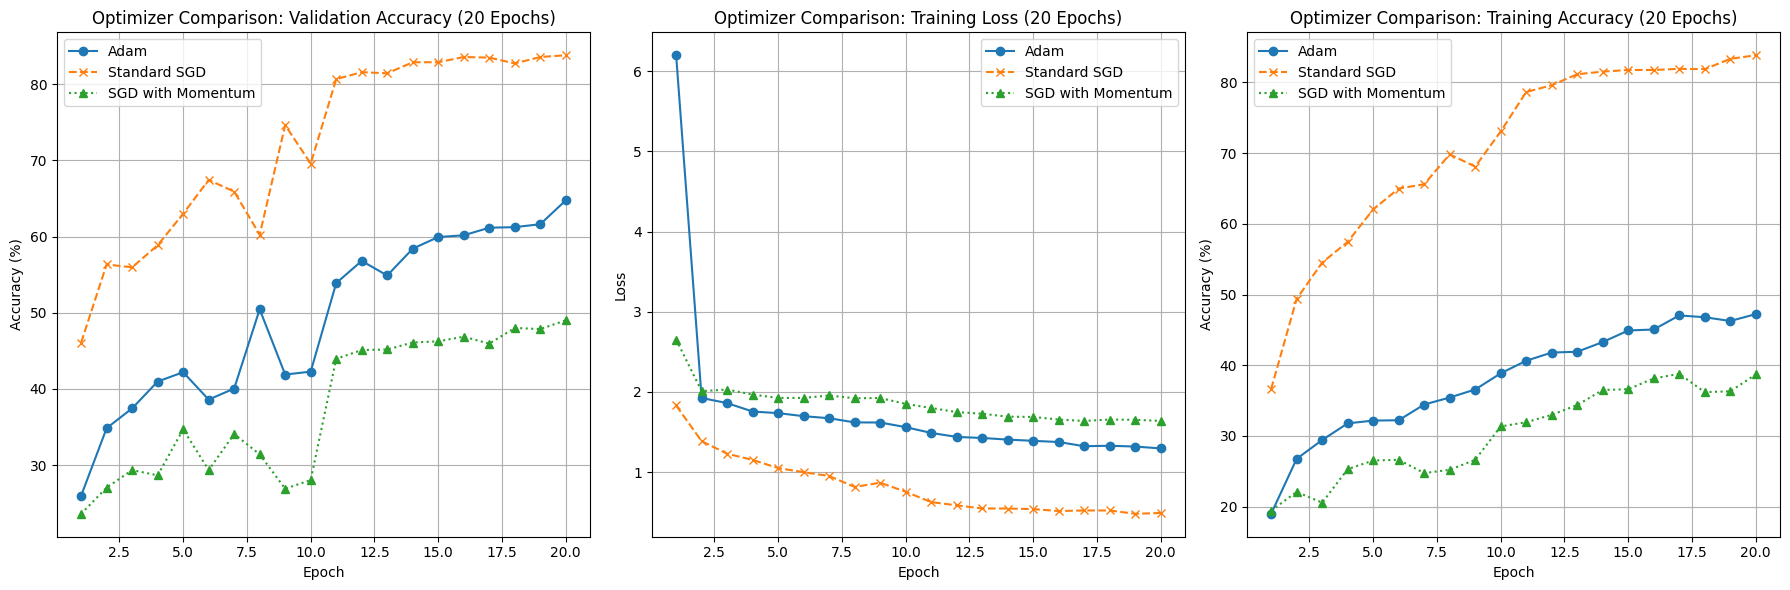


Optimizer Comparison plots generated.


In [17]:
# --- Plotting Comparison ---
plt.figure(figsize=(18, 6))

# Plot Validation Accuracy Comparison
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Validation Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot Training Loss Comparison
plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Training Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Training Accuracy Comparison
plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Training Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nOptimizer Comparison plots generated.")

In [18]:
# --- Evaluate on Test Set Function for Comparison Models ---
def evaluate_on_test_set_comp(model_instance, model_path, test_loader_comp, device_comp):
    model_instance.load_state_dict(torch.load(model_path)) # Load the best weights
    model_instance.to(device_comp)
    model_instance.eval() # Set to evaluation mode

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_loop = tqdm(test_loader_comp, desc=f"Evaluating Test Set for model from {model_path}", leave=False)
        for images, labels in test_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)
            outputs = model_instance(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy

print("\n--- Evaluating Comparison Models on Test Set ---")

adam_final_test_accuracy = evaluate_on_test_set_comp(model_adam_comp, adam_comp_model_path, test_loader, device)
print(f"Adam (Comparison) Final Test Accuracy: {adam_final_test_accuracy:.2f}%\n")

sgd_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_comp, sgd_comp_model_path, test_loader, device)
print(f"Standard SGD (Comparison) Final Test Accuracy: {sgd_final_test_accuracy:.2f}%\n")

sgd_momentum_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device)
print(f"SGD with Momentum (Comparison) Final Test Accuracy: {sgd_momentum_final_test_accuracy:.2f}%\n")

print("\n" + "="*50)
print("       Optimizer Performance Comparison Summary       ")
print("="*50 + "\n")
print(f"Final Test Accuracy for Adam: {adam_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for Standard SGD: {sgd_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for SGD with Momentum: {sgd_momentum_final_test_accuracy:.2f}%")
print("\nOptimizer Comparison Test Evaluation Complete.")


--- Evaluating Comparison Models on Test Set ---


Adam (Comparison) Final Test Accuracy: 63.44%



Standard SGD (Comparison) Final Test Accuracy: 84.59%



SGD with Momentum (Comparison) Final Test Accuracy: 47.73%


       Optimizer Performance Comparison Summary       

Final Test Accuracy for Adam: 63.44%
Final Test Accuracy for Standard SGD: 84.59%
Final Test Accuracy for SGD with Momentum: 47.73%

Optimizer Comparison Test Evaluation Complete.


**Pre trained Model**

In [10]:
# Assuming NUM_EPOCHS_COMP, train_loader, val_loader, test_loader, num_classes, and device
# are already defined from the custom CNN code.

# --- Define Training Function for Transfer Learning ---
def run_transfer_training(model_instance, model_name, optimizer_obj, criterion_obj, scheduler_obj, num_epochs_comp, train_loader_comp, val_loader_comp, device_comp):
    print(f"\nTraining fine-tuned {model_name} for {num_epochs_comp} epochs...")

    current_train_losses = []
    current_train_accuracies = []
    current_val_losses = []
    current_val_accuracies = []

    best_val_acc_run = 0.0
    model_path_run = f'best_transfer_model_{model_name.lower().replace("-", "_")}.pth'

    for epoch in range(num_epochs_comp):
        # Training phase
        model_instance.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({model_name} Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)

            optimizer_obj.zero_grad()
            outputs = model_instance(images)
            loss = criterion_obj(outputs, labels)
            loss.backward()
            optimizer_obj.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader_comp.dataset)
        epoch_train_accuracy = 100 * train_correct / train_total
        current_train_losses.append(epoch_train_loss)
        current_train_accuracies.append(epoch_train_accuracy)

        if scheduler_obj:
            scheduler_obj.step()

        # Validation phase (Step 16: Record validation loss/accuracy)
        model_instance.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            val_loop = tqdm(val_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({model_name} Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device_comp), labels.to(device_comp)
                outputs = model_instance(images)
                loss = criterion_obj(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader_comp.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        current_val_losses.append(epoch_val_loss)
        current_val_accuracies.append(epoch_val_accuracy)

        print(f"  {model_name} - Epoch [{epoch+1}/{num_epochs_comp}] "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.2f}%")

        if epoch_val_accuracy > best_val_acc_run:
            best_val_acc_run = epoch_val_accuracy
            torch.save(model_instance.state_dict(), model_path_run) # Save best model

    print(f"--- {model_name} training finished. Best Val Accuracy: {best_val_acc_run:.2f}% ---")
    return current_train_losses, current_train_accuracies, current_val_losses, current_val_accuracies, model_path_run

print("Transfer learning helper function defined.")

Transfer learning helper function defined.


In [8]:
import torchvision.models as models

# Common configuration
NUM_EPOCHS_COMP = 20 # Using the same number of epochs as the custom CNN [cite: 42]
criterion_transfer = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001 # A common starting LR for fine-tuning

# --- 1. ResNet-18 Transfer Learning ---

# Load pre-trained ResNet-18 model [cite: 57]
model_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the feature extraction layers
# Note: Full freezing (feature extraction) is a valid transfer learning strategy,
# but often for fine-tuning, the last few layers are unfrozen. For simplicity here, we only replace the head.
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (classifier head) for our 9 classes (Fine-tuning)
num_ftrs_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs_resnet, num_classes)
model_resnet = model_resnet.to(device)

# Use Adam optimizer for ResNet fine-tuning
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_resnet = StepLR(optimizer_resnet, step_size=10, gamma=0.1)

# Run Training for ResNet (Step 15 & 16)
resnet_results = run_transfer_training(
    model_resnet, "ResNet-18", optimizer_resnet, criterion_transfer, scheduler_resnet, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
resnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies, resnet_comp_model_path = resnet_results

# --- 2. VGG-16 Transfer Learning ---

# Load pre-trained VGG-16 model [cite: 57]
model_vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all parameters
for param in model_vgg.parameters():
    param.requires_grad = False

# Replace the final classifier head for our 9 classes (Fine-tuning)
# VGG's classifier is a sequential module
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, num_classes)
model_vgg = model_vgg.to(device)

# Use Adam optimizer for VGG fine-tuning
optimizer_vgg = optim.Adam(model_vgg.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_vgg = StepLR(optimizer_vgg, step_size=10, gamma=0.1)

# Run Training for VGG (Step 15 & 16)
vgg_results = run_transfer_training(
    model_vgg, "VGG-16", optimizer_vgg, criterion_transfer, scheduler_vgg, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
vgg_train_losses, vgg_train_accuracies, vgg_val_losses, vgg_val_accuracies, vgg_comp_model_path = vgg_results

print("\nTransfer learning training completed for ResNet and VGG.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 



Training fine-tuned ResNet-18 for 20 epochs...


  ResNet-18 - Epoch [1/20] Train Loss: 1.5715 | Train Acc: 48.48% | Val Loss: 1.1996 | Val Accuracy: 63.48%


  ResNet-18 - Epoch [2/20] Train Loss: 1.0041 | Train Acc: 69.18% | Val Loss: 0.9500 | Val Accuracy: 68.68%


  ResNet-18 - Epoch [3/20] Train Loss: 0.8150 | Train Acc: 75.14% | Val Loss: 0.8194 | Val Accuracy: 73.60%


  ResNet-18 - Epoch [4/20] Train Loss: 0.7486 | Train Acc: 76.83% | Val Loss: 0.7530 | Val Accuracy: 76.40%


  ResNet-18 - Epoch [5/20] Train Loss: 0.6771 | Train Acc: 78.81% | Val Loss: 0.7206 | Val Accuracy: 76.54%


  ResNet-18 - Epoch [6/20] Train Loss: 0.6319 | Train Acc: 80.02% | Val Loss: 0.6993 | Val Accuracy: 76.69%


  ResNet-18 - Epoch [7/20] Train Loss: 0.5727 | Train Acc: 82.73% | Val Loss: 0.6845 | Val Accuracy: 76.97%


  ResNet-18 - Epoch [8/20] Train Loss: 0.5497 | Train Acc: 83.39% | Val Loss: 0.6738 | Val Accuracy: 77.39%


  ResNet-18 - Epoch [9/20] Train Loss: 0.5198 | Train Acc: 83.81% | Val Loss: 0.6755 | Val Accuracy: 76.26%


  ResNet-18 - Epoch [10/20] Train Loss: 0.5222 | Train Acc: 84.20% | Val Loss: 0.6554 | Val Accuracy: 77.95%


  ResNet-18 - Epoch [11/20] Train Loss: 0.4830 | Train Acc: 84.86% | Val Loss: 0.6342 | Val Accuracy: 78.09%


  ResNet-18 - Epoch [12/20] Train Loss: 0.4602 | Train Acc: 86.88% | Val Loss: 0.6357 | Val Accuracy: 77.81%


  ResNet-18 - Epoch [13/20] Train Loss: 0.4818 | Train Acc: 85.98% | Val Loss: 0.6356 | Val Accuracy: 77.53%


  ResNet-18 - Epoch [14/20] Train Loss: 0.4763 | Train Acc: 85.95% | Val Loss: 0.6329 | Val Accuracy: 78.37%


  ResNet-18 - Epoch [15/20] Train Loss: 0.4968 | Train Acc: 84.98% | Val Loss: 0.6362 | Val Accuracy: 77.81%


  ResNet-18 - Epoch [16/20] Train Loss: 0.4809 | Train Acc: 85.50% | Val Loss: 0.6334 | Val Accuracy: 78.51%


  ResNet-18 - Epoch [17/20] Train Loss: 0.4801 | Train Acc: 86.37% | Val Loss: 0.6335 | Val Accuracy: 77.81%


  ResNet-18 - Epoch [18/20] Train Loss: 0.4751 | Train Acc: 85.98% | Val Loss: 0.6257 | Val Accuracy: 77.95%


  ResNet-18 - Epoch [19/20] Train Loss: 0.4562 | Train Acc: 86.55% | Val Loss: 0.6318 | Val Accuracy: 77.81%


  ResNet-18 - Epoch [20/20] Train Loss: 0.4577 | Train Acc: 87.21% | Val Loss: 0.6325 | Val Accuracy: 78.65%
--- ResNet-18 training finished. Best Val Accuracy: 78.65% ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]  



Training fine-tuned VGG-16 for 20 epochs...


  VGG-16 - Epoch [1/20] Train Loss: 1.0600 | Train Acc: 63.35% | Val Loss: 0.8095 | Val Accuracy: 73.31%


  VGG-16 - Epoch [2/20] Train Loss: 0.7009 | Train Acc: 75.02% | Val Loss: 0.6732 | Val Accuracy: 76.40%


  VGG-16 - Epoch [3/20] Train Loss: 0.6156 | Train Acc: 78.69% | Val Loss: 0.6400 | Val Accuracy: 77.67%


  VGG-16 - Epoch [4/20] Train Loss: 0.5552 | Train Acc: 80.26% | Val Loss: 0.6022 | Val Accuracy: 77.95%


  VGG-16 - Epoch [5/20] Train Loss: 0.5092 | Train Acc: 82.31% | Val Loss: 0.5757 | Val Accuracy: 80.34%


  VGG-16 - Epoch [6/20] Train Loss: 0.5191 | Train Acc: 81.07% | Val Loss: 0.5830 | Val Accuracy: 79.35%


  VGG-16 - Epoch [7/20] Train Loss: 0.4828 | Train Acc: 82.55% | Val Loss: 0.5743 | Val Accuracy: 79.49%


  VGG-16 - Epoch [8/20] Train Loss: 0.4385 | Train Acc: 83.90% | Val Loss: 0.5583 | Val Accuracy: 80.20%


  VGG-16 - Epoch [9/20] Train Loss: 0.4375 | Train Acc: 84.83% | Val Loss: 0.5869 | Val Accuracy: 79.92%


  VGG-16 - Epoch [10/20] Train Loss: 0.3883 | Train Acc: 86.49% | Val Loss: 0.5428 | Val Accuracy: 81.46%


  VGG-16 - Epoch [11/20] Train Loss: 0.3821 | Train Acc: 86.22% | Val Loss: 0.5424 | Val Accuracy: 82.16%


  VGG-16 - Epoch [12/20] Train Loss: 0.3849 | Train Acc: 86.16% | Val Loss: 0.5257 | Val Accuracy: 82.30%


  VGG-16 - Epoch [13/20] Train Loss: 0.3874 | Train Acc: 86.94% | Val Loss: 0.5288 | Val Accuracy: 82.87%


  VGG-16 - Epoch [14/20] Train Loss: 0.3747 | Train Acc: 87.03% | Val Loss: 0.5241 | Val Accuracy: 82.72%


  VGG-16 - Epoch [15/20] Train Loss: 0.3912 | Train Acc: 86.52% | Val Loss: 0.5319 | Val Accuracy: 81.88%


  VGG-16 - Epoch [16/20] Train Loss: 0.3638 | Train Acc: 86.28% | Val Loss: 0.5329 | Val Accuracy: 82.44%


  VGG-16 - Epoch [17/20] Train Loss: 0.3755 | Train Acc: 86.07% | Val Loss: 0.5178 | Val Accuracy: 83.29%


  VGG-16 - Epoch [18/20] Train Loss: 0.3707 | Train Acc: 87.27% | Val Loss: 0.5288 | Val Accuracy: 83.01%


  VGG-16 - Epoch [19/20] Train Loss: 0.3649 | Train Acc: 87.27% | Val Loss: 0.5239 | Val Accuracy: 82.16%


  VGG-16 - Epoch [20/20] Train Loss: 0.3746 | Train Acc: 87.21% | Val Loss: 0.5244 | Val Accuracy: 82.44%
--- VGG-16 training finished. Best Val Accuracy: 83.29% ---

Transfer learning training completed for ResNet and VGG.


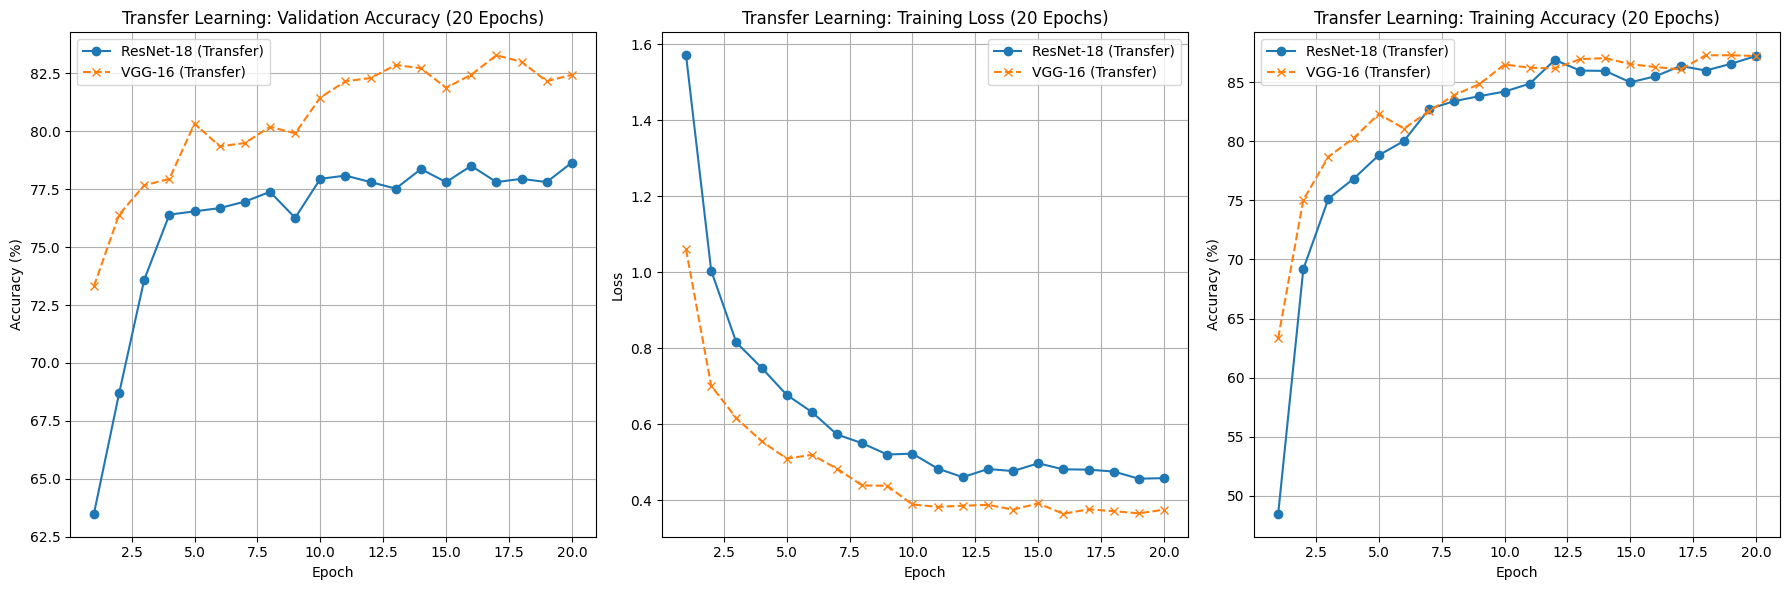


Transfer Learning Comparison plots generated.


NameError: name 'evaluate_on_test_set_comp' is not defined

In [9]:
# --- Plotting Comparison ---
plt.figure(figsize=(18, 6))

# Plot Validation Accuracy Comparison
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), resnet_val_accuracies, marker='o', linestyle='-', label='ResNet-18 (Transfer)')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), vgg_val_accuracies, marker='x', linestyle='--', label='VGG-16 (Transfer)')
plt.title(f"Transfer Learning: Validation Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot Training Loss Comparison
plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), resnet_train_losses, marker='o', linestyle='-', label='ResNet-18 (Transfer)')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), vgg_train_losses, marker='x', linestyle='--', label='VGG-16 (Transfer)')
plt.title(f"Transfer Learning: Training Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Training Accuracy Comparison
plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), resnet_train_accuracies, marker='o', linestyle='-', label='ResNet-18 (Transfer)')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), vgg_train_accuracies, marker='x', linestyle='--', label='VGG-16 (Transfer)')
plt.title(f"Transfer Learning: Training Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nTransfer Learning Comparison plots generated.")

# --- Evaluation on Test Set (Step 17) ---
# Note: You need to ensure the `evaluate_on_test_set_comp` function from your custom CNN code is available in your notebook.

# ResNet-18 Test Evaluation
resnet_final_test_accuracy = evaluate_on_test_set_comp(model_resnet, resnet_comp_model_path, test_loader, device)
print(f"ResNet-18 (Transfer) Final Test Accuracy: {resnet_final_test_accuracy:.2f}%\n")

# VGG-16 Test Evaluation
vgg_final_test_accuracy = evaluate_on_test_set_comp(model_vgg, vgg_comp_model_path, test_loader, device)
print(f"VGG-16 (Transfer) Final Test Accuracy: {vgg_final_test_accuracy:.2f}%\n")

**models tuning**

In [11]:
import torchvision.models as models

# Common configuration
NUM_EPOCHS_COMP = 20 # Using the same number of epochs as the custom CNN [cite: 42]
criterion_transfer = nn.CrossEntropyLoss()
LEARNING_RATE = 0.0005 # A common starting LR for fine-tuning

# --- 1. ResNet-18 Transfer Learning ---

# Load pre-trained ResNet-18 model [cite: 57]
model_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the feature extraction layers
# Note: Full freezing (feature extraction) is a valid transfer learning strategy,
# but often for fine-tuning, the last few layers are unfrozen. For simplicity here, we only replace the head.
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (classifier head) for our 9 classes (Fine-tuning)
num_ftrs_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs_resnet, num_classes)
model_resnet = model_resnet.to(device)

# Use Adam optimizer for ResNet fine-tuning
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_resnet = StepLR(optimizer_resnet, step_size=5, gamma=0.1)

# Run Training for ResNet (Step 15 & 16)
resnet_results = run_transfer_training(
    model_resnet, "ResNet-18", optimizer_resnet, criterion_transfer, scheduler_resnet, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
resnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies, resnet_comp_model_path = resnet_results

# --- 2. VGG-16 Transfer Learning ---

# Load pre-trained VGG-16 model [cite: 57]
model_vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all parameters
for param in model_vgg.parameters():
    param.requires_grad = False

# Replace the final classifier head for our 9 classes (Fine-tuning)
# VGG's classifier is a sequential module
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, num_classes)
model_vgg = model_vgg.to(device)

# Use Adam optimizer for VGG fine-tuning
optimizer_vgg = optim.Adam(model_vgg.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_vgg = StepLR(optimizer_vgg, step_size=5, gamma=0.1)

# Run Training for VGG (Step 15 & 16)
vgg_results = run_transfer_training(
    model_vgg, "VGG-16", optimizer_vgg, criterion_transfer, scheduler_vgg, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
vgg_train_losses, vgg_train_accuracies, vgg_val_losses, vgg_val_accuracies, vgg_comp_model_path = vgg_results

print("\nTransfer learning training completed for ResNet and VGG.")


Training fine-tuned ResNet-18 for 20 epochs...


  ResNet-18 - Epoch [1/20] Train Loss: 1.8034 | Train Acc: 39.57% | Val Loss: 1.5004 | Val Accuracy: 52.25%


  ResNet-18 - Epoch [2/20] Train Loss: 1.2893 | Train Acc: 61.18% | Val Loss: 1.2035 | Val Accuracy: 63.76%


  ResNet-18 - Epoch [3/20] Train Loss: 1.0736 | Train Acc: 68.55% | Val Loss: 1.0368 | Val Accuracy: 66.57%


  ResNet-18 - Epoch [4/20] Train Loss: 0.9551 | Train Acc: 71.53% | Val Loss: 0.9613 | Val Accuracy: 69.10%


  ResNet-18 - Epoch [5/20] Train Loss: 0.8520 | Train Acc: 75.26% | Val Loss: 0.9093 | Val Accuracy: 70.79%


  ResNet-18 - Epoch [6/20] Train Loss: 0.8176 | Train Acc: 76.41% | Val Loss: 0.8931 | Val Accuracy: 70.79%


  ResNet-18 - Epoch [7/20] Train Loss: 0.7946 | Train Acc: 75.87% | Val Loss: 0.8975 | Val Accuracy: 70.22%


  ResNet-18 - Epoch [8/20] Train Loss: 0.7907 | Train Acc: 76.20% | Val Loss: 0.8942 | Val Accuracy: 70.08%


  ResNet-18 - Epoch [9/20] Train Loss: 0.7603 | Train Acc: 78.36% | Val Loss: 0.8842 | Val Accuracy: 70.79%


  ResNet-18 - Epoch [10/20] Train Loss: 0.7646 | Train Acc: 77.55% | Val Loss: 0.8768 | Val Accuracy: 70.79%


  ResNet-18 - Epoch [11/20] Train Loss: 0.7466 | Train Acc: 77.88% | Val Loss: 0.8743 | Val Accuracy: 70.65%


  ResNet-18 - Epoch [12/20] Train Loss: 0.7624 | Train Acc: 77.49% | Val Loss: 0.8838 | Val Accuracy: 70.37%


  ResNet-18 - Epoch [13/20] Train Loss: 0.7695 | Train Acc: 77.25% | Val Loss: 0.8731 | Val Accuracy: 70.65%


  ResNet-18 - Epoch [14/20] Train Loss: 0.7599 | Train Acc: 78.03% | Val Loss: 0.8713 | Val Accuracy: 70.93%


  ResNet-18 - Epoch [15/20] Train Loss: 0.7851 | Train Acc: 76.44% | Val Loss: 0.8785 | Val Accuracy: 70.08%


  ResNet-18 - Epoch [16/20] Train Loss: 0.7669 | Train Acc: 78.09% | Val Loss: 0.8747 | Val Accuracy: 71.21%


  ResNet-18 - Epoch [17/20] Train Loss: 0.7506 | Train Acc: 78.48% | Val Loss: 0.8713 | Val Accuracy: 70.51%


  ResNet-18 - Epoch [18/20] Train Loss: 0.7809 | Train Acc: 76.68% | Val Loss: 0.8727 | Val Accuracy: 70.22%


  ResNet-18 - Epoch [19/20] Train Loss: 0.7482 | Train Acc: 78.54% | Val Loss: 0.8764 | Val Accuracy: 70.37%


  ResNet-18 - Epoch [20/20] Train Loss: 0.7673 | Train Acc: 76.29% | Val Loss: 0.8762 | Val Accuracy: 70.65%
--- ResNet-18 training finished. Best Val Accuracy: 71.21% ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]  



Training fine-tuned VGG-16 for 20 epochs...


  VGG-16 - Epoch [1/20] Train Loss: 1.2217 | Train Acc: 58.71% | Val Loss: 0.8837 | Val Accuracy: 71.07%


  VGG-16 - Epoch [2/20] Train Loss: 0.7804 | Train Acc: 73.61% | Val Loss: 0.7628 | Val Accuracy: 74.72%


  VGG-16 - Epoch [3/20] Train Loss: 0.6915 | Train Acc: 76.38% | Val Loss: 0.7085 | Val Accuracy: 75.98%


  VGG-16 - Epoch [4/20] Train Loss: 0.6252 | Train Acc: 78.39% | Val Loss: 0.6884 | Val Accuracy: 75.00%


  VGG-16 - Epoch [5/20] Train Loss: 0.5739 | Train Acc: 79.75% | Val Loss: 0.6328 | Val Accuracy: 77.25%


  VGG-16 - Epoch [6/20] Train Loss: 0.5509 | Train Acc: 80.83% | Val Loss: 0.6272 | Val Accuracy: 78.51%


  VGG-16 - Epoch [7/20] Train Loss: 0.5379 | Train Acc: 81.73% | Val Loss: 0.6192 | Val Accuracy: 78.23%


  VGG-16 - Epoch [8/20] Train Loss: 0.5404 | Train Acc: 81.79% | Val Loss: 0.6245 | Val Accuracy: 77.53%


  VGG-16 - Epoch [9/20] Train Loss: 0.5408 | Train Acc: 81.88% | Val Loss: 0.6198 | Val Accuracy: 78.79%


  VGG-16 - Epoch [10/20] Train Loss: 0.5331 | Train Acc: 82.76% | Val Loss: 0.6215 | Val Accuracy: 78.93%


  VGG-16 - Epoch [11/20] Train Loss: 0.5374 | Train Acc: 81.43% | Val Loss: 0.6196 | Val Accuracy: 79.21%


  VGG-16 - Epoch [12/20] Train Loss: 0.5312 | Train Acc: 81.76% | Val Loss: 0.6186 | Val Accuracy: 79.07%


  VGG-16 - Epoch [13/20] Train Loss: 0.5211 | Train Acc: 83.09% | Val Loss: 0.6176 | Val Accuracy: 79.21%


  VGG-16 - Epoch [14/20] Train Loss: 0.5177 | Train Acc: 82.91% | Val Loss: 0.6167 | Val Accuracy: 78.79%


  VGG-16 - Epoch [15/20] Train Loss: 0.5275 | Train Acc: 81.64% | Val Loss: 0.6159 | Val Accuracy: 78.93%


  VGG-16 - Epoch [16/20] Train Loss: 0.5221 | Train Acc: 81.94% | Val Loss: 0.6158 | Val Accuracy: 78.93%


  VGG-16 - Epoch [17/20] Train Loss: 0.5340 | Train Acc: 81.07% | Val Loss: 0.6156 | Val Accuracy: 78.93%


  VGG-16 - Epoch [18/20] Train Loss: 0.5311 | Train Acc: 82.52% | Val Loss: 0.6155 | Val Accuracy: 79.21%


  VGG-16 - Epoch [19/20] Train Loss: 0.5397 | Train Acc: 82.21% | Val Loss: 0.6155 | Val Accuracy: 79.07%


  VGG-16 - Epoch [20/20] Train Loss: 0.5311 | Train Acc: 81.34% | Val Loss: 0.6155 | Val Accuracy: 79.07%
--- VGG-16 training finished. Best Val Accuracy: 79.21% ---

Transfer learning training completed for ResNet and VGG.


Above tuning not working xxxxxxxxxxxxxxxxxxxxxxx


========== Training ResNet-18 ==========

Epoch 1/20
------------------------------
Train Loss: 1.2705, Train Acc: 0.5989
Val Loss:   0.8899, Val Acc:   0.7317

Epoch 2/20
------------------------------
Train Loss: 0.5437, Train Acc: 0.8613
Val Loss:   0.6236, Val Acc:   0.8160

Epoch 3/20
------------------------------
Train Loss: 0.3275, Train Acc: 0.9263
Val Loss:   0.5008, Val Acc:   0.8624

Epoch 4/20
------------------------------
Train Loss: 0.2089, Train Acc: 0.9624
Val Loss:   0.4468, Val Acc:   0.8694

Epoch 5/20
------------------------------
Train Loss: 0.1355, Train Acc: 0.9816
Val Loss:   0.4032, Val Acc:   0.8778

Epoch 6/20
------------------------------
Train Loss: 0.0828, Train Acc: 0.9928
Val Loss:   0.3776, Val Acc:   0.8806

Epoch 7/20
------------------------------
Train Loss: 0.0608, Train Acc: 0.9940
Val Loss:   0.3728, Val Acc:   0.8792

Epoch 8/20
------------------------------
Train Loss: 0.0426, Train Acc: 0.9961
Val Loss:   0.3656, Val Acc:   0.8792

Epoch

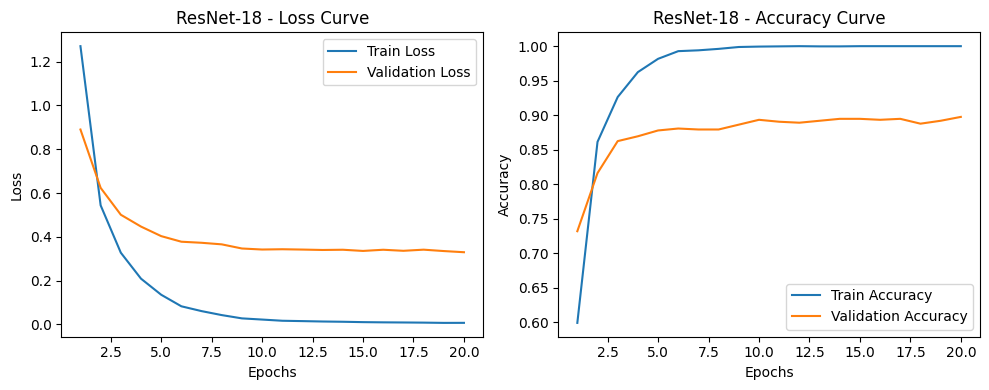

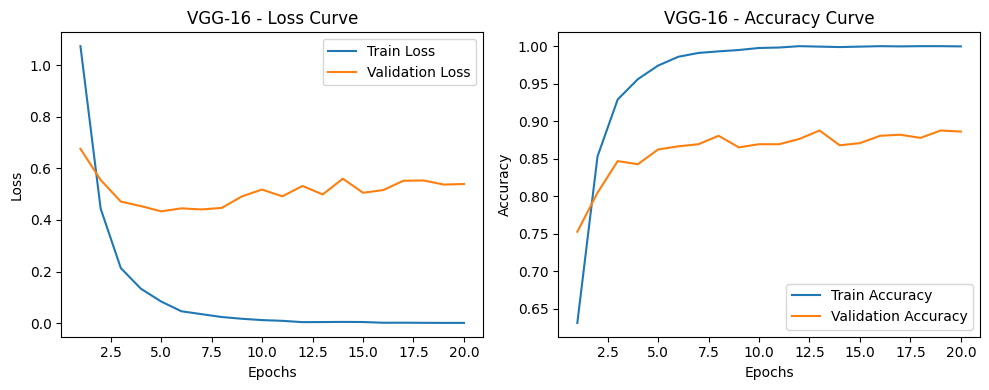


✅ Transfer learning and fine-tuning completed successfully!


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time

# ----------------------------
# Configuration
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9
NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

# ----------------------------
# Helper: Training & Validation Function
# ----------------------------
def train_and_validate(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print(f"\n{'='*10} Training {model_name} {'='*10}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-"*30)

        # --- Training phase ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # --- Validation phase ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {max(val_accuracies):.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# ----------------------------
# Fine-Tuning ResNet-18
# ----------------------------
model_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze everything first
for param in model_resnet.parameters():
    param.requires_grad = False

# Unfreeze last residual block and fully connected layer
for name, param in model_resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Replace final FC layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(filter(lambda p: p.requires_grad, model_resnet.parameters()),
                              lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_resnet = StepLR(optimizer_resnet, step_size=10, gamma=0.5)

# Train ResNet-18
resnet_train_losses, resnet_train_accs, resnet_val_losses, resnet_val_accs = train_and_validate(
    model_resnet, "ResNet-18", train_loader, val_loader,
    criterion, optimizer_resnet, scheduler_resnet, NUM_EPOCHS
)

# ----------------------------
# Fine-Tuning VGG-16
# ----------------------------
model_vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze everything
for param in model_vgg.parameters():
    param.requires_grad = False

# Unfreeze last conv block + classifier
for name, param in model_vgg.named_parameters():
    if "features.24" in name or "features.26" in name or "classifier" in name:
        param.requires_grad = True

# Replace final classifier layer
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, num_classes)
model_vgg = model_vgg.to(device)

optimizer_vgg = optim.Adam(filter(lambda p: p.requires_grad, model_vgg.parameters()),
                           lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_vgg = StepLR(optimizer_vgg, step_size=10, gamma=0.5)

# Train VGG-16
vgg_train_losses, vgg_train_accs, vgg_val_losses, vgg_val_accs = train_and_validate(
    model_vgg, "VGG-16", train_loader, val_loader,
    criterion, optimizer_vgg, scheduler_vgg, NUM_EPOCHS
)

# ----------------------------
# Plotting Results
# ----------------------------
def plot_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    epochs = np.arange(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot both models
plot_curves(resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs, "ResNet-18")
plot_curves(vgg_train_losses, vgg_val_losses, vgg_train_accs, vgg_val_accs, "VGG-16")

print("\n✅ Transfer learning and fine-tuning completed successfully!")


models overfitted.adding data augmentation, dropout, weight decay, and early stopping


========== Training ResNet ==========

Epoch 1/20
------------------------------
Train Loss: 1.3107, Train Acc: 0.5492
Val Loss: 0.7353, Val Acc: 0.7261

Epoch 2/20
------------------------------
Train Loss: 0.7472, Train Acc: 0.7394
Val Loss: 0.5315, Val Acc: 0.8118

Epoch 3/20
------------------------------
Train Loss: 0.6055, Train Acc: 0.7830
Val Loss: 0.4205, Val Acc: 0.8539

Epoch 4/20
------------------------------
Train Loss: 0.5074, Train Acc: 0.8288
Val Loss: 0.4069, Val Acc: 0.8624

Epoch 5/20
------------------------------
Train Loss: 0.4504, Train Acc: 0.8495
Val Loss: 0.4150, Val Acc: 0.8553

Epoch 6/20
------------------------------
Train Loss: 0.4004, Train Acc: 0.8691
Val Loss: 0.3889, Val Acc: 0.8722

Epoch 7/20
------------------------------
Train Loss: 0.3532, Train Acc: 0.8820
Val Loss: 0.4130, Val Acc: 0.8652

Epoch 8/20
------------------------------
Train Loss: 0.3206, Train Acc: 0.8935
Val Loss: 0.3902, Val Acc: 0.8820

Epoch 9/20
-----------------------------

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



========== Training VGG ==========

Epoch 1/20
------------------------------
Train Loss: 1.5859, Train Acc: 0.4048
Val Loss: 0.9529, Val Acc: 0.6713

Epoch 2/20
------------------------------
Train Loss: 0.9869, Train Acc: 0.6590
Val Loss: 0.7281, Val Acc: 0.7570

Epoch 3/20
------------------------------
Train Loss: 0.8258, Train Acc: 0.7099
Val Loss: 0.7298, Val Acc: 0.7654

Epoch 4/20
------------------------------
Train Loss: 0.7067, Train Acc: 0.7454
Val Loss: 0.5780, Val Acc: 0.7963

Epoch 5/20
------------------------------
Train Loss: 0.6147, Train Acc: 0.7866
Val Loss: 0.5539, Val Acc: 0.8202

Epoch 6/20
------------------------------
Train Loss: 0.5426, Train Acc: 0.8164
Val Loss: 0.5716, Val Acc: 0.8174

Epoch 7/20
------------------------------
Train Loss: 0.5114, Train Acc: 0.8255
Val Loss: 0.5959, Val Acc: 0.8132

Epoch 8/20
------------------------------
Train Loss: 0.4811, Train Acc: 0.8354
Val Loss: 0.4940, Val Acc: 0.8287

Epoch 9/20
------------------------------
T

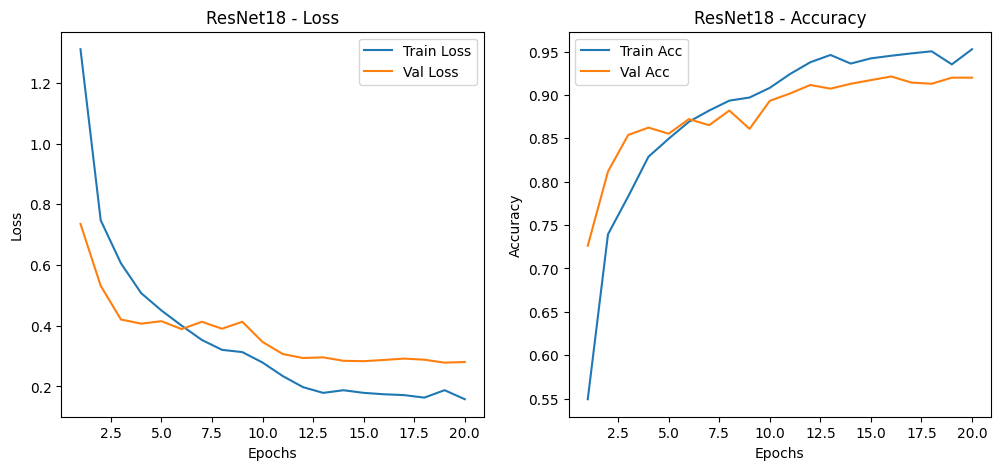

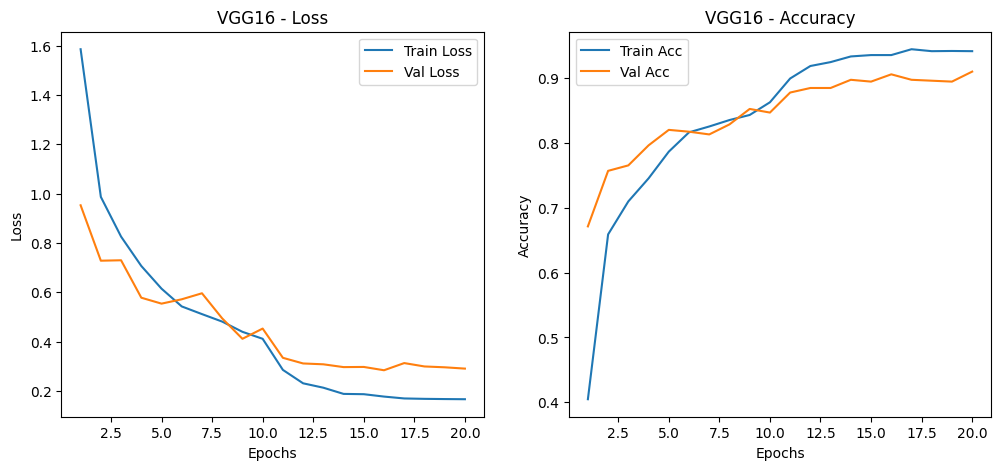

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy
import matplotlib.pyplot as plt

# =============================
# 1. Configuration
# =============================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
DATA_DIR = "/kaggle/working/realwaste_split"   # update with your dataset path

# =============================
# 2. Data Augmentation
# =============================
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(f"{DATA_DIR}/{x}", data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

# =============================
# 3. Training Function (with Early Stopping)
# =============================
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print(f"\n========== Training {model.__class__.__name__} ==========\n")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}\n" + "-"*30)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}")

            # Early stopping based on validation accuracy
            if phase == "val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        print()
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# =============================
# 4. Helper for Model Definition
# =============================
def get_model(model_name, num_classes, fine_tune=True, dropout_p=0.5):
    if model_name == "resnet":
        model = models.resnet18(pretrained=True)
        if not fine_tune:
            for param in model.parameters():
                param.requires_grad = False
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )

    elif model_name == "vgg":
        model = models.vgg16(pretrained=True)
        if not fine_tune:
            for param in model.features.parameters():
                param.requires_grad = False
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )

    return model.to(DEVICE)

# =============================
# 5. Fine-Tuning ResNet18
# =============================
num_classes = len(class_names)
model_resnet = get_model("resnet", num_classes)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_resnet = StepLR(optimizer_resnet, step_size=10, gamma=0.1)

model_resnet, resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc = train_model(
    model_resnet, criterion, optimizer_resnet, scheduler_resnet, num_epochs=EPOCHS
)

# =============================
# 6. Fine-Tuning VGG16
# =============================
model_vgg = get_model("vgg", num_classes)
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_vgg = StepLR(optimizer_vgg, step_size=10, gamma=0.1)

model_vgg, vgg_train_loss, vgg_val_loss, vgg_train_acc, vgg_val_acc = train_model(
    model_vgg, criterion, optimizer_vgg, scheduler_vgg, num_epochs=EPOCHS
)

# =============================
# 7. Plot Results
# =============================
def plot_metrics(train_loss, val_loss, train_acc, val_acc, title):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_metrics(resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc, "ResNet18")
plot_metrics(vgg_train_loss, vgg_val_loss, vgg_train_acc, vgg_val_acc, "VGG16")


**testing**

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Test data transformations (same as val)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder('/kaggle/working/realwaste_split/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


resnet

In [20]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Put model in evaluation mode
# Choose the model to test
model_to_test = model_resnet  # or model_vgg
model_to_test.eval()          # put it in evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_to_test(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


✅ Test Accuracy: 90.93%


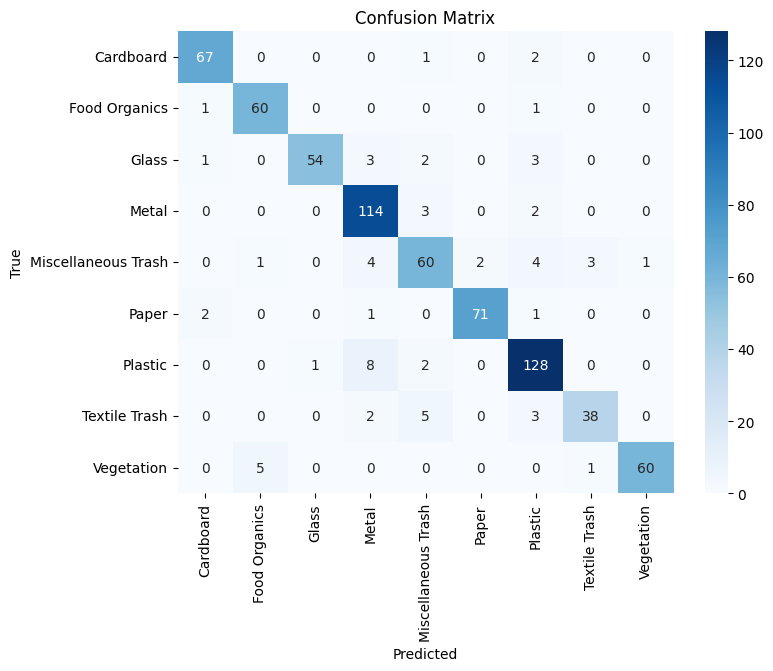


Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.94      0.96      0.95        70
      Food Organics       0.91      0.97      0.94        62
              Glass       0.98      0.86      0.92        63
              Metal       0.86      0.96      0.91       119
Miscellaneous Trash       0.82      0.80      0.81        75
              Paper       0.97      0.95      0.96        75
            Plastic       0.89      0.92      0.90       139
      Textile Trash       0.90      0.79      0.84        48
         Vegetation       0.98      0.91      0.94        66

           accuracy                           0.91       717
          macro avg       0.92      0.90      0.91       717
       weighted avg       0.91      0.91      0.91       717


🔹 Overall Metrics:
Macro Precision: 0.9189
Macro Recall:    0.9009
Macro F1-Score:  0.9084
Weighted Precision: 0.9115
Weighted Recall:    0.9093
Weighted F1-Score:  0.9091


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 🔹 Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 🔹 Overall Metrics
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"\n🔹 Overall Metrics:")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")
print(f"Macro F1-Score:  {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall:    {recall_weighted:.4f}")
print(f"Weighted F1-Score:  {f1_weighted:.4f}")


vgg

In [22]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Put model in evaluation mode
# Choose the model to test
model_to_test = model_vgg  # or model_vgg
model_to_test.eval()          # put it in evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_to_test(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


✅ Test Accuracy: 90.10%


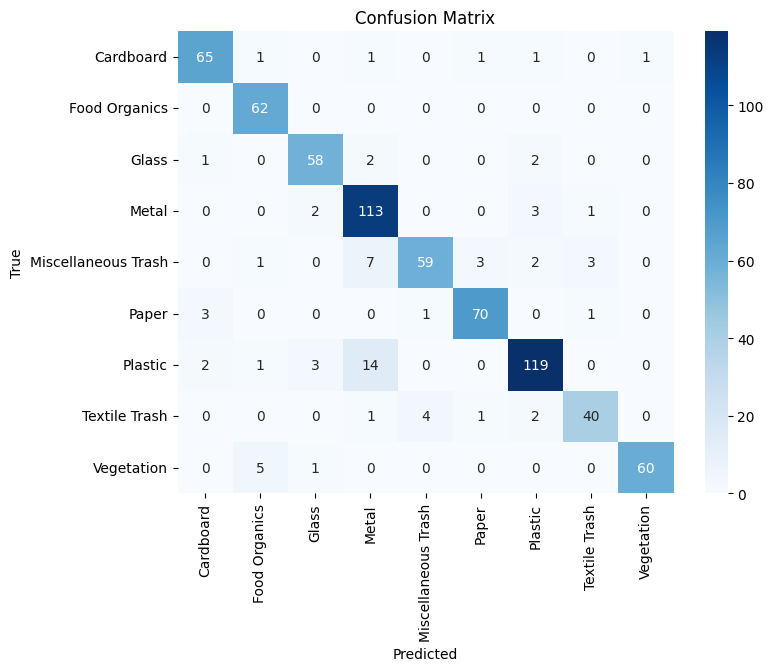


Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.92      0.93      0.92        70
      Food Organics       0.89      1.00      0.94        62
              Glass       0.91      0.92      0.91        63
              Metal       0.82      0.95      0.88       119
Miscellaneous Trash       0.92      0.79      0.85        75
              Paper       0.93      0.93      0.93        75
            Plastic       0.92      0.86      0.89       139
      Textile Trash       0.89      0.83      0.86        48
         Vegetation       0.98      0.91      0.94        66

           accuracy                           0.90       717
          macro avg       0.91      0.90      0.90       717
       weighted avg       0.90      0.90      0.90       717


🔹 Overall Metrics:
Macro Precision: 0.9085
Macro Recall:    0.9019
Macro F1-Score:  0.9033
Weighted Precision: 0.9044
Weighted Recall:    0.9010
Weighted F1-Score:  0.9006


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 🔹 Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 🔹 Overall Metrics
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"\n🔹 Overall Metrics:")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")
print(f"Macro F1-Score:  {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall:    {recall_weighted:.4f}")
print(f"Weighted F1-Score:  {f1_weighted:.4f}")
